## A. Configuración General.

In [1]:
#1. Librerías.

%run "../librerias.ipynb"

/home/gmasi/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/home/gmasi/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#3. Constantes.
%run "../constantes.ipynb"

dataset_preprocesado = dataset_file_fe_all_3

cantidad_meses_train = "all"
ventana = 3

mes_train = mes_train_all_menos_3
mes_test = mes_test

In [3]:
#4. Funciones
%run "../funciones.ipynb"

In [4]:
#5. Lectura de datos.
files = [datasets_path + f"{mes}_{ventana}.parquet" for mes in mes_all]

# Leer y combinar archivos
data = pd.concat([pd.read_parquet(file) for file in files], ignore_index=True)

In [5]:
#6. Pequeño pre-procesamiento sobre los datos.
#i. Cambio tipos de datos (Me lo toma como tipo de dato "object"...)
data['ctrx_quarter_normalizado'] = data['ctrx_quarter_normalizado'].astype(float)
#ii. Elimino columnas de último momento por Data Concept.
columnas_de_interes_prestamos = data.filter(like='prestamos_personales').columns
data.drop(columnas_de_interes_prestamos,axis=1,inplace=True)
#iii. Pesos y reclusterización.
data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

data['clase_binaria1'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0)
data['clase_binaria2'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1)


In [6]:
#iv. Divido entre Train y Test.
train_data = data[data['foto_mes'].isin(mes_train)]
test_data = data[data['foto_mes'] == mes_test]

In [7]:
del data
import gc
gc.collect()

40

In [8]:

#b. Datos para entrenar todo el modelo final para Kaggle.
X_train = train_data.drop(['clase_ternaria', 'clase_peso','clase_binaria2', 'clase_binaria1'], axis=1)
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']

#c. Datos de Test (a predecir).
X_test = test_data.drop(['clase_ternaria', 'clase_peso','clase_binaria2', 'clase_binaria1'], axis=1)
y_test_binaria2 = test_data['clase_binaria2']


## B. Train con cantidad_meses_train meses con df -ventana con ratios incluidos.

In [11]:
#1. Funcion de optimización de hiperparámetros.
def objective(trial): 
    # Rango de parámetros a buscar sus valores óptimos.
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.3)
    stopping_rounds = int(50 + 5 / learning_rate)

    lgb_params = {
        'seed': semillas[0],
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'rf',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_depth': -1,
        'num_threads': -1,
        'verbose': -1,
        'num_boost_round': trial.suggest_int('num_boost_round', 20, 170),
        'max_bin': trial.suggest_int('max_bin', 20, 200),
        'num_leaves': trial.suggest_int('num_leaves', 8, 200),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 200),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'learning_rate': learning_rate,
        'stopping_rounds': stopping_rounds,
    }    # Parámetros que le voy a pasar al modelo.
    
    # Creo el dataset para Light GBM.
    train_data = lgb.Dataset(X_train,
                              label=y_train_binaria2, # eligir la clase
                              weight=w_train)
    
    # Entreno.
    cv_results = lgb.cv(
        lgb_params,
        train_data,
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,
        seed=semillas[0]
    )
    
    # Calculo la ganancia máxima y la mejor iteración donde se obtuvo dicha ganancia.
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 5

In [11]:
import warnings

warnings.filterwarnings("ignore", message="Found `num_boost_round` in params. Will use it instead of argument")

#2. Voy a realizar un estudio de Optuna para encontrar los mejores parámetros.
#i. Creo la base de datos donde guardar los resultados.
storage_name = "sqlite:///" + db_path + "optimization_lgbm.db"

study_name = f"exp_lgbm_{cantidad_meses_train}_{ventana}x" # Primer dígito cuantos meses para atrás desde 06/21, segundo dígito número data drifting.

#ii. Creo el estudio.
study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)


[I 2024-12-08 05:41:59,937] Using an existing study with name 'exp_lgbm_all_3x' instead of creating a new one.


In [13]:
#iii. Corro el estudio.
study.optimize(objective, n_trials=100)

/home/gmasi/.venv/lib/python3.12/site-packages/lightgbm/engine.py:738: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")
[I 2024-11-24 21:29:39,176] Trial 39 finished with value: 1534379000.0 and parameters: {'learning_rate': 0.06154779355165472, 'num_boost_round': 49, 'max_bin': 144, 'num_leaves': 176, 'min_data_in_leaf': 170, 'feature_fraction': 0.5890818662290386, 'bagging_fraction': 0.3055494886397542}. Best is trial 24 with value: 1585423000.0.
/home/gmasi/.venv/lib/python3.12/site-packages/lightgbm/engine.py:738: UserWarning: Found 'num_boost_round' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")
[I 2024-11-24 21:40:13,132] Trial 40 finished with value: 1579221000.0 and parameters: {'learning_rate': 0.04178381128183648, 'num_boost_

KeyboardInterrupt: 

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
plot_param_importances(study)

In [ ]:
plot_slice(study)

In [ ]:
plot_contour(study)

In [ ]:
plot_contour(study, params=['num_leaves','min_data_in_leaf'] )

In [ ]:
study.best_trial.params

In [ ]:
#5. Tomamos el mejor modelo y con eso entrenamos todos los datos.
for x in range(13):
    # best_iter = study.best_trial.user_attrs["best_iter"]
    # print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
    # params2 = study.best_trial.params
    params2 = {'learning_rate': 0.09190593820069065, 'num_boost_round': 135, 'max_bin': 156, 'num_leaves': 192, 'min_data_in_leaf': 200, 'feature_fraction': 0.30941258359379137, 'bagging_fraction': 0.8271949205225773}
    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'rf',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_depth': -1,
        'num_threads': -1,
        'verbose': -1,
        'max_bin': params2['max_bin'],
        'num_boost_round': params2['num_boost_round'],
        'num_leaves': params2['num_leaves'],
        'learning_rate': params2['learning_rate'],
        'min_data_in_leaf': params2['min_data_in_leaf'],
        'feature_fraction': params2['feature_fraction'],
        'bagging_fraction': params2['bagging_fraction'],
        'seed': x,
    }
    
    train_data = lgb.Dataset(X_train,
                              label=y_train_binaria2,
                              weight=w_train)
    
    model_lgb = lgb.train(params, train_data)
    model_lgb.save_model(modelos_path + 'lgbm_base_{}.txt'.format(x))

/home/gmasi/.venv/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/gmasi/.venv/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/gmasi/.venv/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/gmasi/.venv/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/gmasi/.venv/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: 

In [9]:
lgb_models = []
for x in range(13):
    lgb_models.append(lgb.Booster(model_file= modelos_path + 'lgbm_base_{}.txt'.format(x)))

In [13]:
model_lgb = lgb_models[0]
predicciones = model_lgb.predict(X_test)

X_test['Probabilidad'] = predicciones
#iii. Ordenamos a los clientes por probabilidad de ser "BAJA" de forma descendente.
tb_entrega = X_test.sort_values(by='Probabilidad', ascending=False)
#iv. Genero una lista de distintos cortes candidatos, para enviar a Kaggle.
cortes = range(9000,14000,200)
#v. Generamos las distintas predicciones de clases a partir de los distintos cortes posibles.
num_subida_kaggle = 1
i = 0
for envios in cortes:
    #1. Le ponemos clase 1 ("BAJA") a los primeros "envios" con mayor probabilidad.
    tb_entrega['Predicted'] = 0
    tb_entrega.iloc[:envios, tb_entrega.columns.get_loc('Predicted')] = 1
    resultados = tb_entrega[["numero_de_cliente", 'Predicted']].reset_index(drop=True)
    
    print("Cantidad de clientes {}".format(envios))
    #2. Guardamos el archivo para Kaggle.
    nombre_archivo = "K_OH_6_6_00{}.csv".format(num_subida_kaggle) #-X meses, con df de -X meses, número de intento.
    ruta_archivo= "{}/{}".format(exp_path,nombre_archivo)
    resultados.to_csv(ruta_archivo, index=False)
    
    num_subida_kaggle += 1
    i += 1

Cantidad de clientes 9000
Cantidad de clientes 9200
Cantidad de clientes 9400
Cantidad de clientes 9600
Cantidad de clientes 9800
Cantidad de clientes 10000
Cantidad de clientes 10200
Cantidad de clientes 10400
Cantidad de clientes 10600
Cantidad de clientes 10800
Cantidad de clientes 11000
Cantidad de clientes 11200
Cantidad de clientes 11400
Cantidad de clientes 11600
Cantidad de clientes 11800
Cantidad de clientes 12000
Cantidad de clientes 12200
Cantidad de clientes 12400
Cantidad de clientes 12600
Cantidad de clientes 12800
Cantidad de clientes 13000
Cantidad de clientes 13200
Cantidad de clientes 13400
Cantidad de clientes 13600
Cantidad de clientes 13800


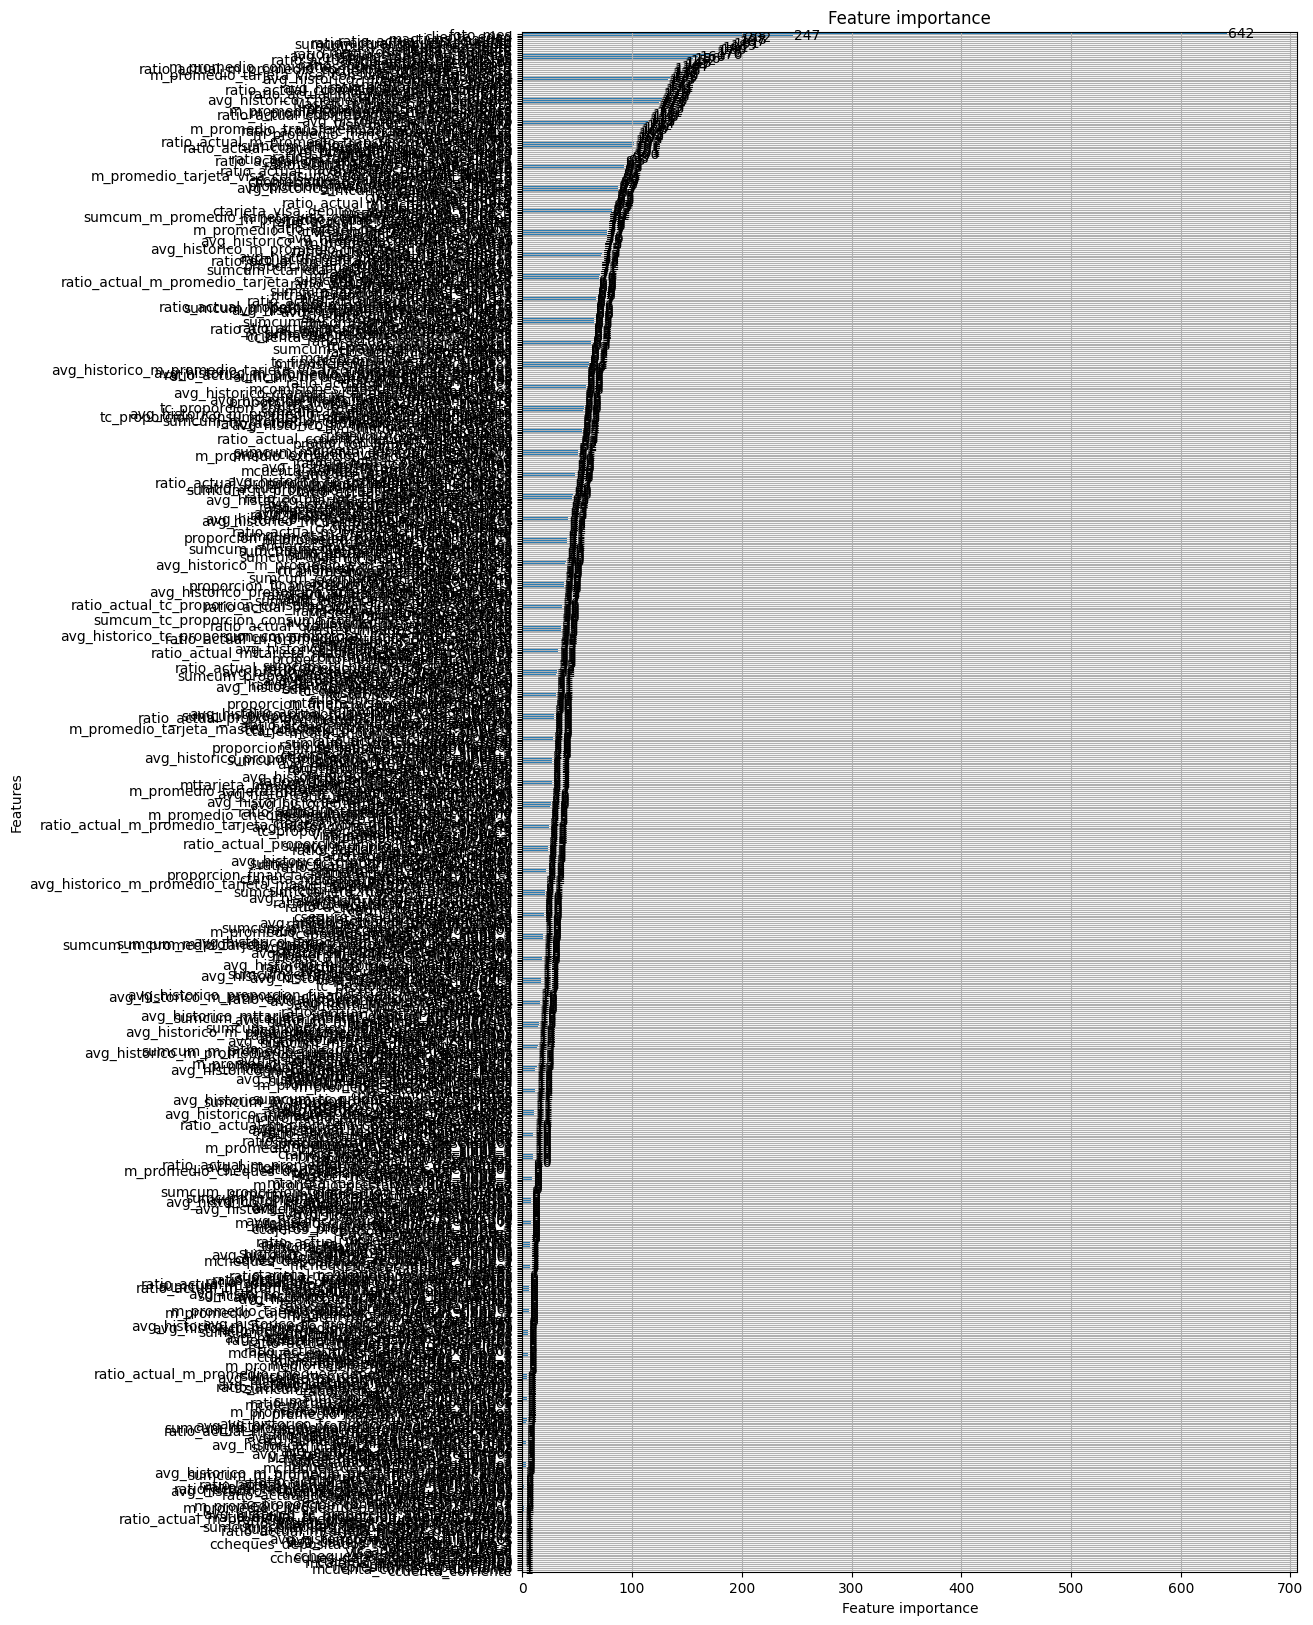

In [16]:
#6. Observamos las variables más importantes para el modelo.
#i. Gráfico.
lgb.plot_importance(model_lgb, figsize=(10, 20))
plt.show()

In [17]:
#ii. Dataframe.
#a. Extract feature importance and feature names.
importance = model_lgb.feature_importance()
features = model_lgb.feature_name()

#b. Create a dataframe for better visualization.
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})

#c. Sort by importance in descending order.
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

#d. show.
importance_df.head(100)

,Feature,Importance
0,foto_mes,642
1,cliente_edad,247
2,mactivos_margen,202
3,ratio_actual_ctrx_quarter,198
4,ratio_actual_mcuentas_saldo,197
...,...,...
95,sumcum_m_promedio_tarjeta_visa_consumo_por_tra...,81
96,m_promedio_comisiones_otras_slope_3,79
97,ratio_actual_tc_pagadopesos_total,78
98,tc_fechacierre_mayor,78


In [22]:
#7. Guardamos el modelo.
# Primer dígito cuantos meses para atrás desde 06/21, segundo dígito número data drifting, tercer dígito número de entrenamiento.
model_lgb.save_model(modelos_path + 'lgbm_{}_{}.txt'.format(cantidad_meses_train,ventana))

In [ ]:
####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################
############## Primera subida orientativa a Kaggle previo medir semillas, etc. #####################
####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################

In [23]:
#8. Volvemos a leer el modelo.
model_lgb = lgb.Booster(model_file= modelos_path + 'lgbm_{}_{}.txt'.format(cantidad_meses_train,ventana))

In [14]:
#a. Importo librería.
from kaggle.api.kaggle_api_extended import KaggleApi
#b. Configura el API de Kaggle
api = KaggleApi()
api.authenticate()

In [15]:
for x in range(len(lgb_models)):
    if x < 4:
        continue
    X_test.drop(['Probabilidad'], axis=1, inplace=True)
    lgb_model = lgb_models[x]
    predicciones = lgb_model.predict(X_test)
    X_test['Probabilidad'] = predicciones
    #iii. Ordenamos a los clientes por probabilidad de ser "BAJA" de forma descendente.
    tb_entrega = X_test.sort_values(by='Probabilidad', ascending=False)
    #iv. Genero una lista de distintos cortes candidatos, para enviar a Kaggle.
    cortes = range(10000,12000,200)
    #v. Generamos las distintas predicciones de clases a partir de los distintos cortes posibles.
    num_subida_kaggle = 1
    
    i = 0
    for envios in cortes:
        #1. Le ponemos clase 1 ("BAJA") a los primeros "envios" con mayor probabilidad.
        tb_entrega['Predicted'] = 0
        tb_entrega.iloc[:envios, tb_entrega.columns.get_loc('Predicted')] = 1
        resultados = tb_entrega[["numero_de_cliente", 'Predicted']].reset_index(drop=True)
        
        print("Cantidad de clientes {}".format(envios))
        #2. Guardamos el archivo para Kaggle.
        nombre_archivo = "base_{}_{}.csv".format(x, num_subida_kaggle) #-X meses, con df de -X meses, número de intento.
        ruta_archivo= "{}/{}".format(exp_path,nombre_archivo)
        resultados.to_csv(ruta_archivo, index=False)
        
        num_subida_kaggle += 1
        i += 1
        
        #3. Envío a Kaggle.
        #a. Defino los parámetros claves.
        mensaje = f'DF {ventana}, punto_corte: {envios}.'
        competencia = 'dm-ey-f-2024-tercera'
        #c. Subo la Submission.
        while i<5:
            print(i)
            api.competition_submit(file_name=ruta_archivo, message=mensaje, competition=competencia)
            print("Submission successful!")
            break
        else:
            print("Esperamos 120 segundos...")
            time.sleep(120)
            api.competition_submit(file_name=ruta_archivo, message=mensaje, competition=competencia)
            print("Submission successful!")
            i= 0
    

Cantidad de clientes 10000
1


100%|██████████| 1.94M/1.94M [00:00<00:00, 3.66MB/s]


Submission successful!
Cantidad de clientes 10200
2


100%|██████████| 1.94M/1.94M [00:00<00:00, 2.10MB/s]


Submission successful!
Cantidad de clientes 10400
3


100%|██████████| 1.94M/1.94M [00:00<00:00, 3.70MB/s]


Submission successful!
Cantidad de clientes 10600
4


100%|██████████| 1.94M/1.94M [00:00<00:00, 3.54MB/s]


Submission successful!
Cantidad de clientes 10800
Esperamos 120 segundos...


100%|██████████| 1.94M/1.94M [00:00<00:00, 3.62MB/s]


Submission successful!
Cantidad de clientes 11000
1


100%|██████████| 1.94M/1.94M [00:00<00:00, 3.62MB/s]


Submission successful!
Cantidad de clientes 11200
2


100%|██████████| 1.94M/1.94M [00:00<00:00, 3.65MB/s]


Submission successful!
Cantidad de clientes 11400
3


100%|██████████| 1.94M/1.94M [00:00<00:00, 3.57MB/s]


Submission successful!
Cantidad de clientes 11600
4


100%|██████████| 1.94M/1.94M [00:00<00:00, 3.60MB/s]


Submission successful!
Cantidad de clientes 11800
Esperamos 120 segundos...


100%|██████████| 1.94M/1.94M [00:00<00:00, 3.58MB/s]


Submission successful!
Cantidad de clientes 10000
1


100%|██████████| 1.94M/1.94M [00:00<00:00, 3.33MB/s]


Submission successful!
Cantidad de clientes 10200
2


100%|██████████| 1.94M/1.94M [00:00<00:00, 3.62MB/s]


Submission successful!
Cantidad de clientes 10400
3


100%|██████████| 1.94M/1.94M [00:00<00:00, 3.60MB/s]


Submission successful!
Cantidad de clientes 10600
4


100%|██████████| 1.94M/1.94M [00:00<00:00, 3.71MB/s]


Submission successful!
Cantidad de clientes 10800
Esperamos 120 segundos...


100%|██████████| 1.94M/1.94M [00:00<00:00, 3.30MB/s]


Submission successful!
Cantidad de clientes 11000
1


100%|██████████| 1.94M/1.94M [00:00<00:00, 3.59MB/s]


Submission successful!
Cantidad de clientes 11200
2


100%|██████████| 1.94M/1.94M [00:00<00:00, 3.64MB/s]


Submission successful!
Cantidad de clientes 11400
3


100%|██████████| 1.94M/1.94M [00:00<00:00, 3.44MB/s]


Submission successful!
Cantidad de clientes 11600
4


100%|██████████| 1.94M/1.94M [00:00<00:00, 3.59MB/s]


Submission successful!
Cantidad de clientes 11800
Esperamos 120 segundos...


100%|██████████| 1.94M/1.94M [00:00<00:00, 3.59MB/s]


Submission successful!
Cantidad de clientes 10000
1


100%|██████████| 1.94M/1.94M [00:00<00:00, 3.50MB/s]


Submission successful!
Cantidad de clientes 10200
2


100%|██████████| 1.94M/1.94M [00:00<00:00, 3.58MB/s]


Submission successful!
Cantidad de clientes 10400
3


100%|██████████| 1.94M/1.94M [00:00<00:00, 3.38MB/s]


Submission successful!
Cantidad de clientes 10600
4


100%|██████████| 1.94M/1.94M [00:00<00:00, 3.67MB/s]


Submission successful!
Cantidad de clientes 10800
Esperamos 120 segundos...


100%|██████████| 1.94M/1.94M [00:00<00:00, 3.41MB/s]


Submission successful!
Cantidad de clientes 11000
1


100%|██████████| 1.94M/1.94M [00:00<00:00, 3.28MB/s]


Submission successful!
Cantidad de clientes 11200
2


100%|██████████| 1.94M/1.94M [00:00<00:00, 3.66MB/s]


Submission successful!
Cantidad de clientes 11400
3


100%|██████████| 1.94M/1.94M [00:00<00:00, 3.54MB/s]


Submission successful!
Cantidad de clientes 11600
4


100%|██████████| 1.94M/1.94M [00:00<00:00, 3.68MB/s]


Submission successful!
Cantidad de clientes 11800
Esperamos 120 segundos...


100%|██████████| 1.94M/1.94M [00:00<00:00, 3.26MB/s]


Submission successful!
Cantidad de clientes 10000
1


100%|██████████| 1.94M/1.94M [00:00<00:00, 3.56MB/s]


Submission successful!
Cantidad de clientes 10200
2


100%|██████████| 1.94M/1.94M [00:00<00:00, 3.55MB/s]


Submission successful!
Cantidad de clientes 10400
3


100%|██████████| 1.94M/1.94M [00:00<00:00, 3.44MB/s]
/home/gmasi/.venv/lib/python3.12/site-packages/kaggle/api/kaggle_api.py:1055: SyntaxWarning: invalid escape sequence '\&'
  """Creates (aka \&quot;drops\&quot;) a new file into the inbox.  # noqa: E501
/home/gmasi/.venv/lib/python3.12/site-packages/kaggle/api/kaggle_api.py:1076: SyntaxWarning: invalid escape sequence '\&'
  """Creates (aka \&quot;drops\&quot;) a new file into the inbox.  # noqa: E501
/home/gmasi/.venv/lib/python3.12/site-packages/kaggle/api_client.py:244: SyntaxWarning: invalid escape sequence '\['
  sub_kls = re.match('list\[(.*)\]', klass).group(1)
/home/gmasi/.venv/lib/python3.12/site-packages/kaggle/api_client.py:249: SyntaxWarning: invalid escape sequence '\('
  sub_kls = re.match('dict\(([^,]*), (.*)\)', klass).group(2)


ApiException: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Content-Type': 'application/json', 'Date': 'Mon, 09 Dec 2024 16:02:04 GMT', 'Access-Control-Allow-Credentials': 'true', 'Access-Control-Allow-Origin': '*', 'Set-Cookie': 'ka_sessionid=2ef031b137614825234762a663d2864f; max-age=2626560; path=/, GCLB=CJbltrqV7K-1kQEQAw; path=/; HttpOnly', 'Vary': 'Accept-Encoding', 'X-Kaggle-MillisecondsElapsed': '103', 'X-Kaggle-RequestId': '2bdd7285f5e81fcebeda5bede4d111d9', 'X-Kaggle-ApiVersion': '1.6.17', 'X-Kaggle-HubVersion': '0.3.4', 'X-Frame-Options': 'SAMEORIGIN', 'Strict-Transport-Security': 'max-age=63072000; includeSubDomains; preload', 'Content-Security-Policy': "object-src 'none'; script-src 'nonce-Je5TsiWzftFzDhoHq+Ikuw==' 'report-sample' 'unsafe-inline' 'unsafe-eval' 'strict-dynamic' https: http:; base-uri 'none'; report-uri https://csp.withgoogle.com/csp/kaggle/20201130; frame-src 'self' https://www.kaggleusercontent.com https://www.youtube.com/embed/ https://polygraph-cool.github.io https://www.google.com/recaptcha/ https://www.docdroid.com https://www.docdroid.net https://kaggle-static.storage.googleapis.com https://kkb-production.jupyter-proxy.kaggle.net https://kkb-production.firebaseapp.com https://kaggle-metastore.firebaseapp.com https://apis.google.com https://content-sheets.googleapis.com/ https://accounts.google.com/ https://storage.googleapis.com https://docs.google.com https://drive.google.com https://calendar.google.com/ ;", 'X-Content-Type-Options': 'nosniff', 'Referrer-Policy': 'strict-origin-when-cross-origin', 'Via': '1.1 google', 'Alt-Svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000', 'Transfer-Encoding': 'chunked'})
HTTP response body: {"code":400,"message":"Submission not allowed:  Your team has used its daily Submission allowance (100) today, please try again tomorrow UTC (8.0 hours from now)."}


In [25]:
from scipy.stats import wilcoxon
x = np.array([124313,124360,123496,123823,124578,123100,123364])
y = np.array([119553,120183,118285,119981,119063,118153,119141])
res = wilcoxon(x, y, alternative='greater')
res

WilcoxonResult(statistic=28.0, pvalue=0.0078125)